#  Задание

Собраны исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания, чтобы избежать ситуации с недостаком или избыточностью машин в аэропорте.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.



## Подготовка

In [245]:
# импорты и библиотеки
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor

Прочитаем данные, установим время как индекс и проверим на монотонность

In [246]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = 'datetime')
data.info()
display(data.index.is_monotonic)
display(data.head(20))
display(data.tail(20))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


True

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
datetime,
2018-08-31 20:40:00,16
2018-08-31 20:50:00,18
2018-08-31 21:00:00,24
2018-08-31 21:10:00,29
2018-08-31 21:20:00,23
2018-08-31 21:30:00,27
2018-08-31 21:40:00,29
2018-08-31 21:50:00,27
2018-08-31 22:00:00,34


### Итог подготовки данных

Имеем массив данных в виде временного радя с шагом 10 минут за период с 01 марта 2018 по 31 августа 2018 года. Всего 26496 полных записей без пропусков

## Анализ

Преобразуем данные к почасовым и посмотрим график загрузки

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


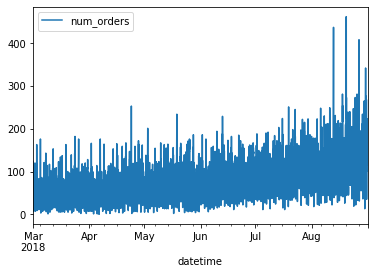

In [247]:
data = data.resample('1H').sum()
data.info()
data.plot()

Какие-то страшные выбросы в августе, надо посмотреть

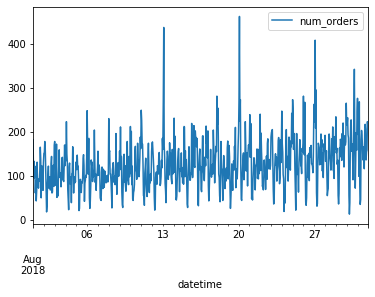

In [248]:
data['2018-08-01':'2018-08-31'].plot()

13, 20, 27 августа! Похоже на недельные пики в отпускной сезон. 

Проверим на тренды и сезонность взяв за единицу 1 день.

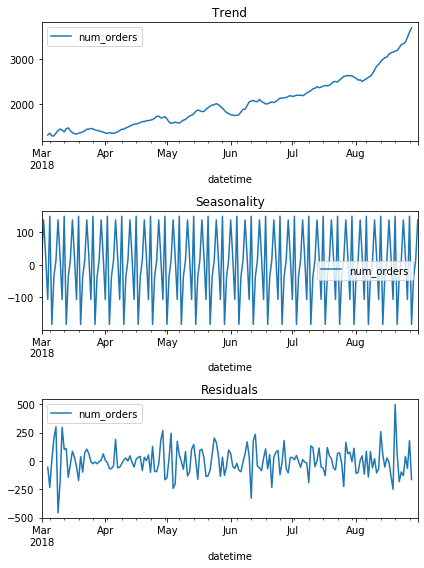

In [249]:
decomposed = seasonal_decompose(data.resample('1D').sum())

plt.figure(figsize=(6, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Увеличим масштаб графика сезонности за один месяц, например, август

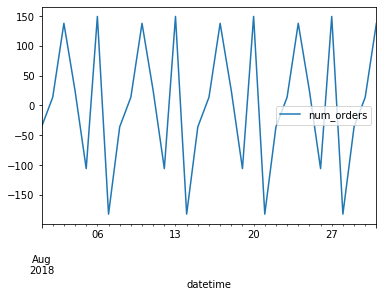

In [250]:
decomposed.seasonal['2018-08-01':'2018-08-31'].plot(ax=plt.gca()) 


Ну да! Пятница все улетают, понедельник возврашаются. А во вторник таксисты могут брать выходной или ездить в других частях города.

### Итоги анализа

Проанализировав временной ряд по суммарному количеству машин в день,  можно сделать следующие выводы:
- имеется растущий тренд запроса количества машин от марта к августу
- имеется ярко выраженая тенденция недельных колебаний требуемого количества машин: пятница и понедельник необходимо большое количество машин, во вторник спрос резко падает.

## Обучение

На основе анализа примем следующие исходные данные для обучения модели предсказания количества машин в аэропорту:
- в качестве признаков будем использовать день и месяц. Это позволит отображать текущий тренд
- в признаки поставим день недели. Это позволит отражать "сезонность", недельный колебания.
- для подбора параметров модели будем использовать глубину отстающих значений и размер окна скользящего среднего.

In [251]:
# функция принимает массив данных, добавляет в его копию признаки месяца, дня и дня недели,
# а затем организует набор данных для обучения и тестирования модели
def make_features(data, max_lag, rolling_mean_size):
    data_def = data.copy()
    data_def['month'] = data_def.index.month
    data_def['day'] = data_def.index.day
    data_def['hour'] = data_def.index.hour
    data_def['dayofweek'] = data_def.index.dayofweek

    #print('Сдвиг ',max_lag)
    for lag in range(1, max_lag + 1):
        data_def['lag_{}'.format(lag)] = data_def['num_orders'].shift(lag)

    data_def['rolling_mean'] = data_def['num_orders'].shift().rolling(rolling_mean_size).mean()
    train, test = train_test_split(data_def, shuffle=False, test_size=0.1)
    train = train.dropna()

    features_train = train.drop('num_orders', axis = 1)
    features_test = test.drop('num_orders', axis = 1)
    target_train = train['num_orders']
    target_test = test['num_orders']
    
    return features_train, features_test,target_train, target_test


Попробуем варьировать глубиной отставания и скользящим средним в разных пределах. Таким образом, мы сможем захватить как тренд, так и сезонность.

Выведем параметры подбора в одно место

### Модель линейной регрессии

In [252]:
Min_roll = 80
Max_roll = 150
Step_roll = 10
Min_lag = 20
Max_lag = 100
Step_lag = 10

In [253]:
#%%time
best_rmse_train = 120000
for roll in range(Min_roll, Max_roll, Step_roll):
    
    for lag in range(Min_lag, Max_lag, Step_lag):
        features_train, features_test,target_train, target_test = make_features(data, lag, roll)
        
        tscv = TimeSeriesSplit(n_splits = 5)
        scores = []
        for train_index, valid_index in tscv.split(features_train):
            #print("TRAIN:", train_index.min(),train_index.max(), "TEST:",valid_index.min(), valid_index.max())
            #print('===========')
            
            features_train_cv = features_train.iloc[train_index]
            features_valid_cv = features_train.iloc[valid_index]
            target_train_cv = target_train.iloc[train_index]
            target_valid_cv = target_train.iloc[valid_index]
            #display(features_train_cv)
            #display(target_train_cv)
            
            model = LinearRegression()
            model.fit(features_train_cv,target_train_cv)
            pred_valid = model.predict(features_valid_cv)
            score = mean_squared_error(pred_valid, target_valid_cv)
            scores.append(score)
        rmse_train = pd.Series(scores).mean()
        #print('Окно', roll, 'Отставание',lag,'Метрика',rmse_train**0.5)
            
        
        if rmse_train < best_rmse_train:
            best_model = model
            best_rmse_train = rmse_train
            best_roll = roll
            best_lag = lag
            best_features_test = features_test
            best_target_test = target_test
        
print('Параметры лучшей модели:') 
print('Отставание: ', best_lag)
print('Ширина окна: ', best_roll )
print("RMSE обучающей выборки:", best_rmse_train**0.5)



Параметры лучшей модели:
Отставание:  80
Ширина окна:  130
RMSE обучающей выборки: 24.263090097317097


### Модель решающего дерева

Проведем аналогичную работу с моделью решающего дерева

In [254]:
Min_roll = 80
Max_roll = 150
Step_roll = 10
Min_lag = 20
Max_lag = 100
Step_lag = 10
Min_depth = 1
Max_depth = 7
Step_depth = 1

In [255]:
#%%time
best_rmse_train_dt = 120000
for depth in range(Min_depth, Max_depth, Step_depth):
    
    for roll in range(Min_roll, Max_roll, Step_roll):
        
        for lag in range(Min_lag, Max_lag, Step_lag):
            features_train, features_test,target_train, target_test = make_features(data, lag, roll)
            
            tscv = TimeSeriesSplit(n_splits = 5)
            scores = []
            for train_index, valid_index in tscv.split(features_train):
                #print("TRAIN:", train_index.min(),train_index.max(), "TEST:",valid_index.min(), valid_index.max())
                #print('===========')
            
                features_train_cv = features_train.iloc[train_index]
                features_valid_cv = features_train.iloc[valid_index]
                target_train_cv = target_train.iloc[train_index]
                target_valid_cv = target_train.iloc[valid_index]
                #display(features_train_cv)
                #display(target_train_cv)
            
                model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
                model.fit(features_train_cv,target_train_cv)
                pred_valid = model.predict(features_valid_cv)
                score = mean_squared_error(pred_valid, target_valid_cv)
                scores.append(score)
            rmse_train = pd.Series(scores).mean()
            
        
            if rmse_train < best_rmse_train_dt:
                best_model_dt = model
                best_depth = depth
                best_rmse_train_dt = rmse_train
                best_roll_dt = roll
                best_lag_dt = lag
                best_features_test_dt = features_test
                best_target_test_dt = target_test
                #print('Глубина', best_depth)
                #print('Отставание: ', best_lag_dt)
                #print('Ширина окна: ', best_roll_dt )
                #print("RMSE обучающей выборки:", best_rmse_train_dt**0.5)
        
print('Параметры лучшей модели:') 
print('Глубина', best_depth)
print('Отставание: ', best_lag_dt)
print('Ширина окна: ', best_roll_dt )
print("RMSE обучающей выборки:", best_rmse_train_dt**0.5)


Параметры лучшей модели:
Глубина 5
Отставание:  90
Ширина окна:  120
RMSE обучающей выборки: 28.458950413154025


## Тестирование

У нас сохранены лучшие параметры на тренировочной выборке для метода кросс-валидации  для дух моделей: линейной регрессии и решающего дерева. Проверим результаты на тестовой выборке

### Тест на Линейной регрессии

In [270]:
pred_test = best_model.predict(best_features_test)
rmse_test = mean_squared_error(pred_test, best_target_test)
print("RMSE тестовой выборки: ", rmse_test**0.5)

RMSE тестовой выборки:  43.689982825427414


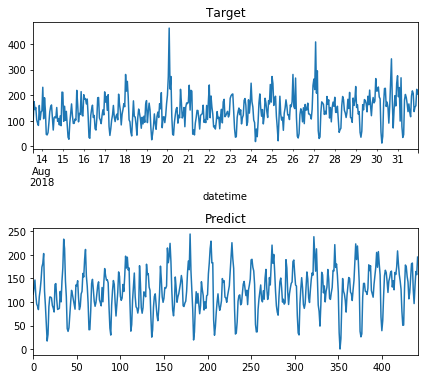

In [271]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
best_target_test.plot(ax=plt.gca())
plt.title('Target')
plt.subplot(312)
pd.Series(pred_test).plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Predict')

plt.tight_layout()

### Тест на решающем дереве

In [268]:
pred_test = best_model_dt.predict(best_features_test_dt)
rmse_test = mean_squared_error(pred_test, best_target_test_dt)
print("RMSE тестовой выборки: ", rmse_test**0.5)

RMSE тестовой выборки:  57.18180909990516


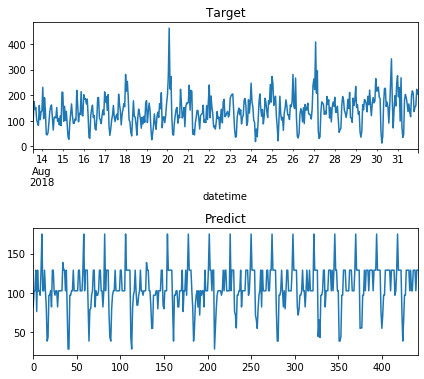

In [269]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
best_target_test_dt.plot(ax=plt.gca())
plt.title('Target')
plt.subplot(312)
pd.Series(pred_test).plot(ax=plt.gca()) # < напишите код здесь >
plt.title('Predict')

plt.tight_layout()

## Выводы

Нам был представлен исторический массив почасовых данных заказанных такси в аэропорту. Необходимо было сделать анализ этих данных и разработать модель, позволяющую  предсказывать потребность в такси на определнный час. В качестве точности прогноза была установлена метрика RMSE не более 48

При анализе данных были обнаружены две тенденции:
- растуший тренд на такси в аэропорту
- имеется ярко выраженая тенденция недельных колебаний требуемого количества машин: пятница и понедельник необходимо большое количество машин, во вторник спрос резко падает.

Далее были построены две модели , предсказывающая необходимое количество машин. Массив данных был разделен в соотношении 9/1 на тренировочную и тестовую выборки. В качестве модели была принята линейная регрессия, в качестве гиперпараметров была принята глубина отстающих значений и размер окна скользящего среднего. Для тренировки использовалась кросс-валидация.

В итоге было определено, что на модели решающего дерева результат на тестовой выборке 43,68, что полностью соответствует требованию задания. А вот решающее дерево показало на тестовой выборке горадо худший результат и не удовлетворяет условиям задачи.



